In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from tqdm import tqdm
import datetime

from keras.layers import BatchNormalization, Dropout, LSTM, Dense, Flatten, MaxPooling1D
from keras.layers import ConvLSTM2D, Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, MaxPooling1D

from keras.callbacks import EarlyStopping


import tensorflow as tf


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [266]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

merge_df = pd.DataFrame(index = range(5783))

for each in regions:
    df = pd.read_csv('{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)

                        
    for i in df.columns:
        df[i] = df[i].fillna(method='ffill')
    
    merge_df = pd.concat([merge_df, df], axis = 1)


In [267]:
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]
count_regions = ['Count_{}'.format(i) for i in regions]
sqrt_fire_regions = ['sqrt_{}'.format(i) for i in fire_regions]

merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)
merge_df['Date'] = pd.date_range(start = '2005-01-01', end = '2020-10-31')
merge_df.set_index('Date', inplace=True)

for i,x in zip(fire_regions, count_regions):
    merge_df['sqrt_{}'.format(i)] = np.sqrt(merge_df[i])
    merge_df['sqrt_{}'.format(x)] = np.sqrt(merge_df[i]/merge_df[x]) * merge_df[x]
    
merge_df.fillna(0, inplace=True)



In [268]:
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)

In [269]:
# import datetime
# date_time = merge_df.index
# timestamp = date_time.map(datetime.datetime.timestamp)
# year = 365.2425 * 24 * 60 * 60
# merge_df['year_sin'] = np.sin(timestamp * (2 * np.pi / year))
# merge_df['year_cos'] = np.cos(timestamp * (2 * np.pi / year))

In [291]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.00000,4.945000,38.831579,0.0,0.0,0.0,36.382500,0.0,0.044274,36.355567,...,6.231499,27.162474,0.0,0.0,0.0,0.0,0.000000,0.00000,6.031791,24.127163
2005-01-02,0.00000,1.320000,64.464286,0.0,0.0,2.8,148.106471,0.0,0.173879,38.699607,...,8.028965,42.485292,0.0,0.0,0.0,0.0,1.673320,1.67332,12.169900,70.962103
2005-01-03,0.00000,88.740000,47.386585,0.0,0.0,1.0,60.632258,0.0,3.011912,49.365152,...,6.883791,44.077772,0.0,0.0,0.0,0.0,1.000000,1.00000,7.786672,43.354354
2005-01-04,8.68000,0.000000,30.100000,0.0,0.0,0.0,86.374167,3.0,2.808620,57.095628,...,5.486347,26.877500,0.0,0.0,0.0,0.0,0.000000,0.00000,9.293770,55.762622
2005-01-05,16.61125,0.000000,4.000000,0.0,0.0,0.0,31.378947,8.0,0.157935,47.170735,...,2.000000,4.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,5.601691,24.417207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,1.21000,12.750000,78.670769,0.0,0.0,0.0,32.970000,1.0,2.124025,65.191496,...,8.869654,71.509440,0.0,0.0,0.0,0.0,0.000000,0.00000,5.741951,19.043897
2020-10-28,3.00000,144.990566,119.608649,0.0,0.0,2.0,20.840625,3.0,4.350241,65.642208,...,10.936574,66.524582,0.0,0.0,0.0,0.0,1.414214,2.00000,4.565153,18.260613
2020-10-29,0.00000,53.462326,249.090625,0.0,0.0,0.0,136.083077,0.0,2.342508,59.019745,...,15.782605,218.690192,0.0,0.0,0.0,0.0,0.000000,0.00000,11.665465,72.850806


In [292]:
train = merge_df[:'2019-10-31']
test = merge_df['2019-11-01':'2020-03-02']

In [293]:
test.shape

(123, 77)

In [294]:

tf.keras.backend.clear_session()

In [295]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(train)
_train = scaler.transform(train)
_train.shape

(5417, 77)

In [296]:

def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :7]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [297]:
n_steps_in, n_steps_out = 123, 123

In [298]:
X, y = split_sequence(_train, n_steps_in, n_steps_out)
y.shape

(5172, 123, 7)

In [299]:
X.shape

(5172, 123, 77)

In [300]:
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

In [301]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]

In [302]:
y.shape

(5172, 861)

In [303]:
n_output

861

In [304]:
X_train, y_train = X[:-365,:,:], y[:-365,:]
X_valid, y_valid = X[-365:, :, :], y[-365:, :]

In [305]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)

    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
pred_seq_train = Dense(n_output, activation = 'relu')(out)

model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss= 'mean_squared_error', metrics = ['mae'])

In [306]:
history = model.fit(X_train, y_train, epochs = 100, callbacks = [lr_schedule], validation_data = (X_valid, y_valid))

Epoch 1/100
151/151 [==============================] - 15s 102ms/step - loss: 0.0029 - mae: 0.0288 - val_loss: 0.0027 - val_mae: 0.0264
Epoch 2/100
151/151 [==============================] - 13s 87ms/step - loss: 0.0027 - mae: 0.0269 - val_loss: 0.0025 - val_mae: 0.0245
Epoch 3/100
151/151 [==============================] - 12s 81ms/step - loss: 0.0025 - mae: 0.0253 - val_loss: 0.0024 - val_mae: 0.0230
Epoch 4/100
151/151 [==============================] - 13s 84ms/step - loss: 0.0024 - mae: 0.0240 - val_loss: 0.0024 - val_mae: 0.0217
Epoch 5/100
151/151 [==============================] - 13s 88ms/step - loss: 0.0023 - mae: 0.0230 - val_loss: 0.0024 - val_mae: 0.0208
Epoch 6/100
151/151 [==============================] - 12s 79ms/step - loss: 0.0023 - mae: 0.0223 - val_loss: 0.0024 - val_mae: 0.0201
Epoch 7/100
151/151 [==============================] - 12s 78ms/step - loss: 0.0022 - mae: 0.0218 - val_loss: 0.0024 - val_mae: 0.0196
Epoch 8/100
151/151 [==============================] -

KeyboardInterrupt: 

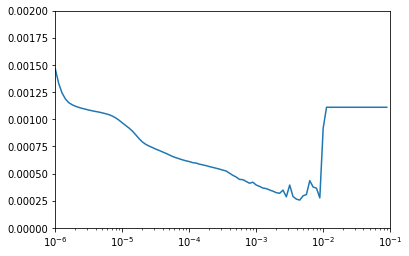

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, .002]);

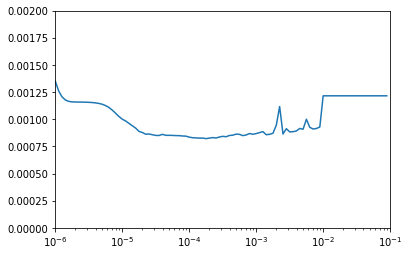

In [27]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, .002]);

In [307]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))


# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)

out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)


pred_seq_train = Dense(n_output, activation = 'relu')(out)
model = Model(history_seq, pred_seq_train)


optimizer = tf.keras.optimizers.Adam(lr = 1e-4)


model.compile(optimizer, loss='mean_squared_error', metrics = ['mae'])

In [308]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid))

Epoch 1/100
151/151 [==============================] - 14s 92ms/step - loss: 0.0027 - mae: 0.0235 - val_loss: 0.0023 - val_mae: 0.0184
Epoch 2/100
151/151 [==============================] - 12s 79ms/step - loss: 0.0020 - mae: 0.0182 - val_loss: 0.0021 - val_mae: 0.0169
Epoch 3/100
151/151 [==============================] - 12s 79ms/step - loss: 0.0018 - mae: 0.0169 - val_loss: 0.0019 - val_mae: 0.0164
Epoch 4/100
151/151 [==============================] - 12s 78ms/step - loss: 0.0017 - mae: 0.0159 - val_loss: 0.0018 - val_mae: 0.0163
Epoch 5/100
151/151 [==============================] - 12s 79ms/step - loss: 0.0016 - mae: 0.0153 - val_loss: 0.0018 - val_mae: 0.0162
Epoch 6/100
151/151 [==============================] - 12s 79ms/step - loss: 0.0015 - mae: 0.0150 - val_loss: 0.0018 - val_mae: 0.0166
Epoch 7/100
151/151 [==============================] - 12s 79ms/step - loss: 0.0015 - mae: 0.0148 - val_loss: 0.0018 - val_mae: 0.0167
Epoch 8/100
151/151 [==============================] - 

KeyboardInterrupt: 

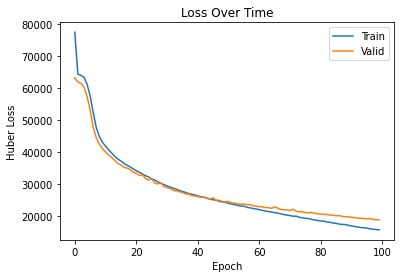

In [220]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [315]:
x_input = np.array(train.iloc[-123:].values)
x_input = scaler.transform(x_input)

In [316]:
x_input.shape

(123, 77)

In [317]:
x_input = x_input.reshape((1, n_steps_in, n_features))

In [350]:
yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 861)

In [351]:
yhat_df = pd.DataFrame(yhat.reshape(123,7), index = test.index, columns = fire_regions)

In [352]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2019-11-01,0.000000,0.057143,0.141795,0.010589,0.0,0.000000,0.068437
2019-11-02,0.000000,0.068175,0.130840,0.007477,0.0,0.000000,0.061792
2019-11-03,0.000000,0.054268,0.129852,0.000733,0.0,0.000000,0.075383
2019-11-04,0.000000,0.057170,0.127219,0.009474,0.0,0.000000,0.068002
2019-11-05,0.000000,0.050913,0.139026,0.013330,0.0,0.000000,0.067882
...,...,...,...,...,...,...,...
2020-02-27,0.002710,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2020-02-28,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.011454
2020-02-29,0.010698,0.000000,0.000000,0.000000,0.0,0.000000,0.014360


In [353]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0

In [354]:
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [355]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,0.000000,578.345042,552.811395,17.555918,0.0,0.00000,578.376725,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-02,0.000000,689.994501,510.101959,12.396704,0.0,0.00000,522.223892,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-03,0.000000,549.238430,506.249360,1.215420,0.0,0.00000,637.083563,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-04,0.000000,578.610776,495.981960,15.708095,0.0,0.00000,574.706253,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-05,0.000000,515.290959,542.013707,22.101122,0.0,0.00000,573.686755,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27,5.573681,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-28,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,96.801043,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-29,22.003933,0.000000,0.000000,0.000000,0.0,0.00000,121.360179,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [356]:
test

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,126.333187,68.370714,24.507143,0.000000,0.0,0.00,127.060357,91.0,0.646422,39.618650,...,4.950469,22.685899,0.000000,0.000000,0.0,0.0,0.00000,0.000000,11.272105,84.352712
2019-11-02,79.587368,103.395556,40.510833,11.597143,0.0,0.00,246.085714,57.0,6.345006,60.935982,...,6.364812,22.048356,3.405458,9.009994,0.0,0.0,0.00000,0.000000,15.687119,180.912686
2019-11-03,13.970000,45.084545,43.038667,4.680000,0.0,0.00,411.561429,12.0,10.946352,78.123328,...,6.560386,35.932715,2.163331,3.059412,0.0,0.0,0.00000,0.000000,20.286977,303.627667
2019-11-04,108.308571,10.412500,46.405882,0.000000,0.0,0.00,857.290658,35.0,0.807121,56.413287,...,6.812186,28.087364,0.000000,0.000000,0.0,0.0,0.00000,0.000000,29.279526,645.479093
2019-11-05,48.942121,23.124545,62.456333,20.750000,0.0,0.00,948.480000,33.0,0.144822,47.964062,...,7.902932,43.286141,4.555217,14.404860,0.0,0.0,0.00000,0.000000,30.797402,514.418040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27,7.911429,0.000000,1.430000,0.000000,0.0,0.00,19.152500,7.0,0.505206,45.087274,...,1.195826,1.195826,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.376357,15.160145
2020-02-28,5.508000,0.000000,9.293333,0.000000,1.0,3.30,0.000000,5.0,0.178557,48.498570,...,3.048497,7.467262,0.000000,0.000000,1.0,1.0,1.81659,3.146427,0.000000,0.000000
2020-02-29,13.000000,0.000000,22.995000,0.000000,0.0,3.36,0.000000,6.0,0.054360,47.417610,...,4.795310,16.611442,0.000000,0.000000,0.0,0.0,1.83303,2.592296,0.000000,0.000000


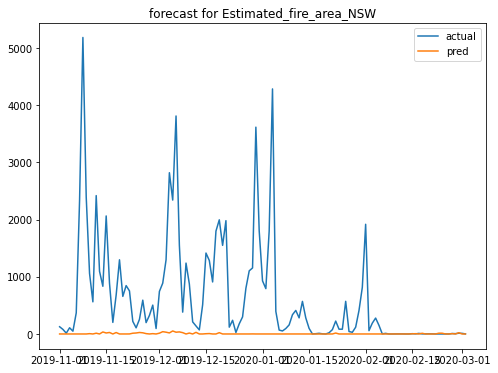

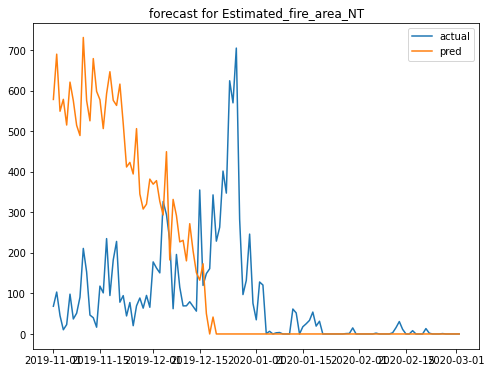

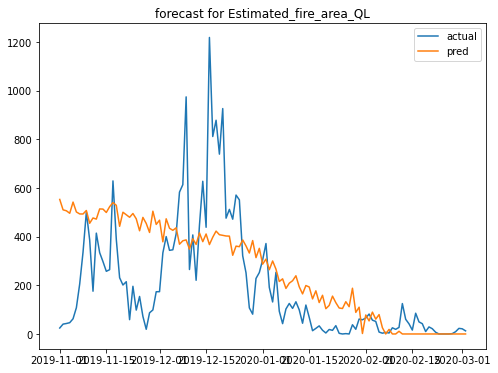

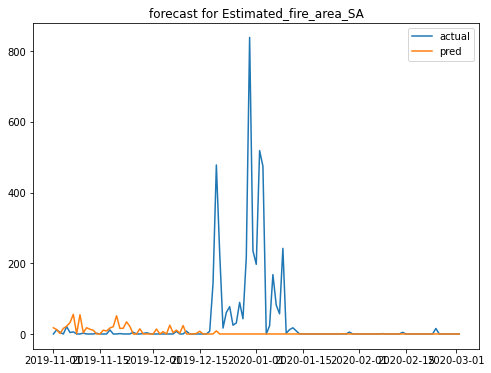

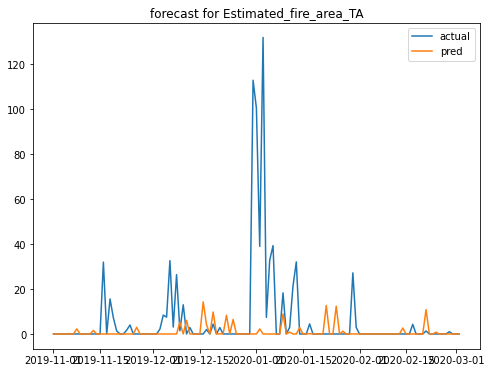

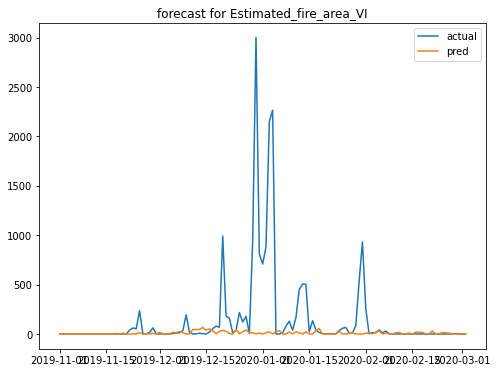

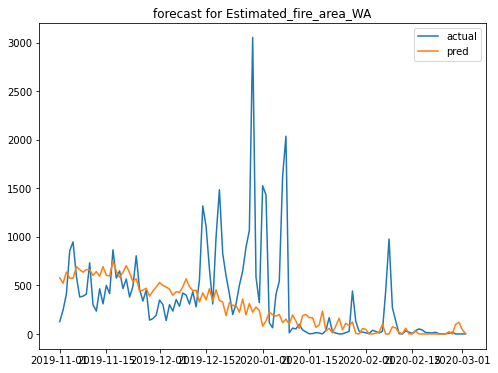

In [358]:
for i in fire_regions:

    plt.figure(figsize=(8,6))
    plt.plot(test[:'2020-03'][i], label = 'actual')
    plt.plot(yhat_df[:'2020-03'][i], label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [ ]:
for i in regions:

    plt.figure(figsize=(8,6))
    plt.plot(np.exp(test[:'2020-03'][i]) - 1, label = 'actual')
    plt.plot(np.exp(yhat_df[:'2020-03'][i]) - 1, label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = (np.exp(yhat_df['2020-02':][regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][regions].values)-1).flatten())

mse = mean_squared_error(y_true = (np.exp(yhat_df['2020-02':][regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][regions].values)-1).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}

In [45]:
_results

{'dcnn_log1p': {'mae': 27.935948853070276, 'mse': 23578.32271703908}}